<a href="https://colab.research.google.com/github/xanasa14/Finances/blob/main/VisOptStrat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
#https://github.com/mullenba/option_visualization/blob/main/option_visualization.ipynb
!pip install yfinance
!pip install yahoofinancials
!pip install mibian


In [36]:
import yfinance as yf
import json

symbol = "WMT"

# Create the object representing the symbol of interest
equity = yf.Ticker(symbol)

current_price = equity.info['currentPrice']
print(f"Current price of {symbol} - ${current_price}")

Current price of WMT - $144.69


In [37]:
# Lets choose the options out a few days
expiration_date = equity.options[1]
print("Expiration Date: ", expiration_date)

# get option chain for specific expiration
opt = equity.option_chain(expiration_date)

# Choosing a strike price appropriate for our strategy
strike_price = 160

# Get the available data for the option contract with our chosen strike price
option_data_at_strike = opt.calls.loc[opt.calls['strike'] == strike_price]
implied_volatility = option_data_at_strike['impliedVolatility'].values[0]
print(f"Option Implied Volatility: {implied_volatility}")

Expiration Date:  2022-01-14
Option Implied Volatility: 0.270515107421875


In [38]:
from datetime import date

current_date_object = date.today()
expiration_date_object = date.fromisoformat(expiration_date)

# We need the number of days until expiration for our plots
days_to_expire = (expiration_date_object - current_date_object).days

In [39]:
import numpy as np
np.set_printoptions(suppress=True)

# Create an array of possible share prices starting $20 below the current
# price and ending $20 above the current price, at $1 intervals.
share_prices = np.arange(current_price-20, current_price+20, 1)

In [40]:
import mibian

def create_value_matrix(prices, 
                        number_of_days, 
                        strike, 
                        implied_volatility):
    # Create an empty array to hold the estimated option values
    output_array = np.zeros((len(prices), number_of_days))

    # For each possible share price...
    for i, p in enumerate(prices):
        # ...and each day from now to expiration
        for d in range(number_of_days):
            # Get the Black-Scholes data for the contract assuming the 
            # given price and days until expiration
            bsData = mibian.BS([p, strike, 0, number_of_days - d], 
                               volatility= implied_volatility*100)
            
            # For the sake of this tutorial, we're doing strategies with calls.
            # Puts are similar
            price = bsData.callPrice
            output_array[i,d] = round(price, 2)
            
    return output_array
        
price_matrix = create_value_matrix(share_prices, 
                                   days_to_expire, 
                                   strike_price, 
                                   implied_volatility)

# Keep in mind, the origin of the points on the matrix is in the upper left,
# this means it's upside down from what we're expecting, with higher share
# prices increasing from top to bottom and days counting from left to right.
print(price_matrix)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.   0.   0.   0.   0

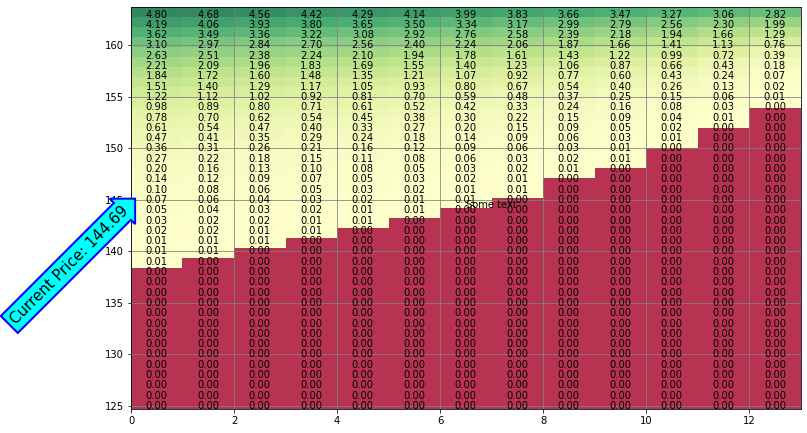

In [41]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patheffects as PathEffects






# We want to take an arbitrary price matrix and display it nicely
def display_value_matrix(matrix, 
                         share_prices, 
                         days_to_expire, 
                         underlying_price):
    fig, ax = plt.subplots(figsize=(12,12))

    for x in range(days_to_expire):
        for i in range(len(share_prices)-1):
            y = share_prices[i]
            txt = ax.text(x+0.5,y , "{:.2f}".format(matrix[i,x]), 
                          ha='center', color='k')

    divnorm=colors.TwoSlopeNorm(vmin=np.min(matrix), 
                                vcenter=0.0001, 
                                vmax=np.max(matrix))
            
    ax.imshow(matrix, origin="lower", cmap="RdYlGn", alpha=0.8,
              extent = [0 , days_to_expire, 
                        share_prices[0], share_prices[-1]],
              norm=divnorm)
    
    ax.text(0, underlying_price, 
            "Current Price: {:.2f}".format(underlying_price), 
            ha="right", va="top", rotation=45, size=15,
            bbox=dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2))

    ax.grid(which="both", c="grey", linewidth=0.8)

    ax.set_aspect(0.2)
    plt.text(0.5, 0.5, 'Some text', transform=ax.transAxes)

    plt.show()
    
display_value_matrix(price_matrix, 
                     share_prices, 
                     days_to_expire, 
                     current_price)

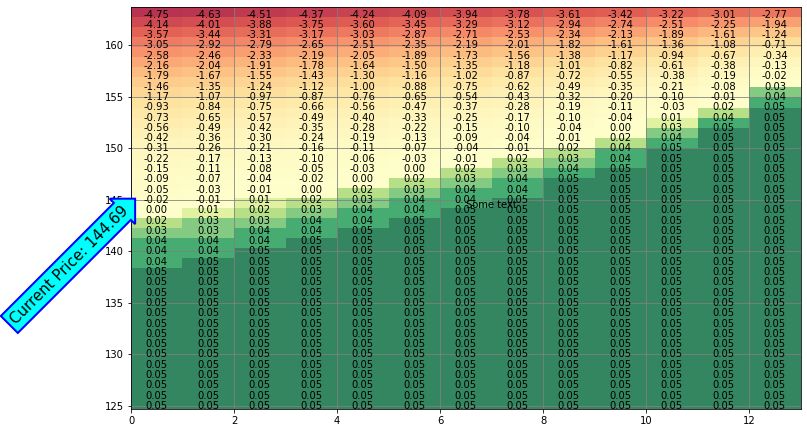

In [42]:
# Short Call

# Get the current price of the option we want to sell
current_option_price = option_data_at_strike['lastPrice'].values[0]

# Now, the values of our matrix will be the money we get from selling 
# the option, minus the current value of the option.
# For example, if we were to sell the option for $1, then immediately 
# buy it back to close the position, it would effectively have no value.
# +$1 selling, -$1 buying to close = $1-$1 = $0
short_values = current_option_price - price_matrix

display_value_matrix(short_values, share_prices, days_to_expire, current_price)

Short Price:  0.33
Long Price:  0.05


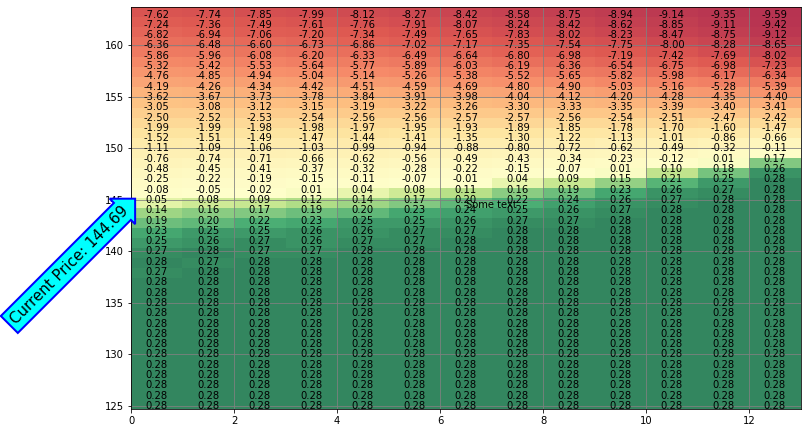

In [43]:
# More complicated strategies - Call Credit Spread

# Short (sell) position
short_strike_price = 150
short_option_data_at_strike = opt.calls.loc[opt.calls['strike'] == short_strike_price]
short_implied_volatility = short_option_data_at_strike['impliedVolatility'].values[0]
short_option_price = short_option_data_at_strike['lastPrice'].values[0]
short_call_matrix = create_value_matrix(share_prices, 
                                        days_to_expire, 
                                        short_strike_price, 
                                        short_implied_volatility)

print("Short Price: ", short_option_price)

# Long (buy) position
long_strike_price = 160
long_option_data_at_strike = opt.calls.loc[opt.calls['strike'] == long_strike_price]
long_implied_volatility = long_option_data_at_strike['impliedVolatility'].values[0]
long_option_price = long_option_data_at_strike['lastPrice'].values[0]
long_call_matrix = create_value_matrix(share_prices, 
                                       days_to_expire, 
                                       long_strike_price, 
                                       long_implied_volatility)

print("Long Price: ", long_option_price)

# The entry cost is the amount we get when we first buy and sell our options
entry_cost = short_option_price - long_option_price

# The matrix for this position is the entry cost minus the amount 
# it would take to close the positions.
call_spread_matrix = entry_cost - short_call_matrix + long_call_matrix

display_value_matrix(call_spread_matrix, 
                     share_prices, 
                     days_to_expire, 
                     current_price)

There are many common strategies that involve multiple options in a single position. An example is a "Call Credit Spread" also known as a "Bear Call Spread". This is a bearish strategy, where you are expecting the underlying stock to go down. It consists of buying a call option with a strike price above the current share price (called "Out of the Money") and at the same time selling a call option with a strike below the current share price ("In the Money"). The difference in price between the two options is the maximum profit you can get from the trade, assuming the stock price does go down at expiration.
